# Example notebook for hydrological analysis of IFS and CaMa-Flood output

## import necessary packages

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
from array import array
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
from matplotlib import colors,colorbar
import cartopy.feature as cf
import datetime

## import necessary functions

In [2]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [3]:
def find_common_elements(arr1, arr2):
    # Convert arrays to sets for faster lookup
    set1 = set(arr1)
    set2 = set(arr2)
    # Find intersection of the sets (common elements)
    common_elements = set1.intersection(set2)
    return list(common_elements)

In [4]:
def worldmap(var,cbar,clabel = None,**kwargs):
    """
    Plot a variable on a Robinson projection world map.

    The function creates a Robinson projection world map using the provided variable
    'var'. 
    
    Args:
        var (array-like): The variable to be plotted on the world map.
        cbar (bool): A boolean flag to indicate whether to display the colorbar. If True,
            a colorbar will be shown; otherwise, no colorbar will be displayed.
        **kwargs: Additional keyword arguments to pass to the `nnshow` function.
    """
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(14, 7), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if cbar is not False:
        cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
        if clabel == None: # Set the label for the colorbar
            cbar.set_label(" ")
        else:
            cbar.set_label(clabel)

## Load data directly from the catalog

In [5]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [6]:
# which IFS experiments are available?
print(list(cat.IFS))

['IFS_9-FESOM_5-production', 'IFS_9-FESOM_5-production-hist', 'IFS_9-FESOM_5-production-old-prepurge', 'IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_28-FESOM_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_9-FESOM_5-production-hist-coupspinup', 'IFS_9-FESOM_5-production-hist-coupspinup-deepon', 'IFS_grids']


In [7]:
print(list(cat.IFS['IFS_28-NEMO_25-cycle3']))

['2D_1h_camaflood', '2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_1deg', '3D_1h6h_1deg', '2D_monthly_1deg', '3D_monthly_1deg', 'WAM_1h_native']


## Catchment-average water balance analysis

### dS/dt = P - ET - Rg - Rs 
### Water storage = Precipitation - Evapotranspiration - Drainage - Runoff

In [16]:
ds28_sfc=cat.IFS['IFS_28-NEMO_25-cycle3']['2D_monthly_0.25deg'].to_dask() # load monthly IFS output regridded to a 0.25 degree regular lat/lon grid 

In [11]:
ds28_sfc

<xarray.Dataset>
Dimensions:  (time: 60, value: 1038240)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-15 2020-02-15 ... 2024-12-15
Dimensions without coordinates: value
Data variables: (12/63)
    100u     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

### Use Ervins script () and CaMa-Flood metadata to compute averages of surface variables upstream of a selected grid cell

In [17]:
# python3 -u ${LIBDIR}/calc_upstream_fieldset.py -ivar ${param} -iriv ${RIVDIR}/ncdata.nc -ifile files6h.grb -imap ${RIVDIR}/inpmat_${inpmat_res}.nc -ovar ${param} -ovarlong "$longname6h" -ovarunit $unit -o fieldint6h -o1 flux6h -o2 areaavg6h -idate %YM1%01 -itime $itime -inum $((daynum*4)) -istep 6

## Runoff coefficient: the fraction of precipitation that is partitioned into a fast runoff components that may lead to hydrological extremes (floods)
### surface runoff (sro) / total precipitation (tp)

In [31]:
# Define longitudes and latitudes both as arrays as a mesh from the xarray data array
lons28_sfc = np.linspace(min(ds28_sfc.lon.values),round(max(ds28_sfc.lon.values),2),len(np.unique(ds28_sfc.lon.values)))
lats28_sfc = np.linspace(min(ds28_sfc.lat.values),max(ds28_sfc.lat.values),len(np.unique(ds28_sfc.lat.values)))
mesh_lons28_sfc, mesh_lats28_sfc = np.meshgrid(np.unique(ds28_sfc.lon),np.unique(ds28_sfc.lat))

In [45]:
# Compute mean of calendar year for total precipitation (tp) and surface runoff (sro)
# Runoff coefficient should stay between 0 and 1
# Runoff coefficient should be computed over several years. If not, the chance increases that surface runoff could generated in the day before the calendar month starts, 
# leading to values that fall outside the range of 0-1. 
# Values can further deviate from 0-1, as surface runoff can travel between grid cells. 
ds28_sfc_tp_calmon = ds28_sfc['tp'].groupby("time.month").mean()
ds28_sfc_sro_calmon = ds28_sfc['sro'].groupby("time.month").mean()
# Select April as the calendar month of interest for now
sample_sfc_tp=np.reshape(ds28_sfc_tp_calmon.isel(month=4).values,(np.shape(mesh_lons28_sfc)))
sample_sfc_sro=np.reshape(ds28_sfc_sro_calmon.isel(month=4).values,(np.shape(mesh_lons28_sfc)))
# Remove all zero's
no0_sample_sfc_tp = np.where(sample_sfc_tp == 0, np.nan, 1)
no0_sample_sfc_sro = np.where(sample_sfc_sro == 0, np.nan, 1)
mask_sample_sfc_tp = sample_sfc_tp * no0_sample_sfc_tp
mask_sample_sfc_sro = sample_sfc_sro * no0_sample_sfc_sro
# Compute the runoff coefficient
sample_sfc_RC = mask_sample_sfc_sro/mask_sample_sfc_tp

In [35]:
# As for illustration purposes I'm interested in the Rhine basin, one could already mask out the Rhine basin from the xarray...

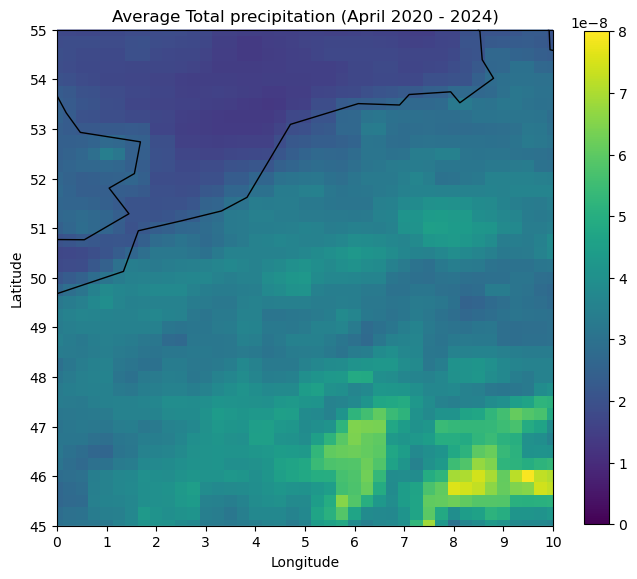

In [38]:
fig, axs = plt.subplots(figsize=(8,8), facecolor="white",subplot_kw={'projection': ccrs.PlateCarree()})

axs.pcolormesh(lons28_sfc, lats28_sfc, sample_sfc_tp[::-1], transform=ccrs.PlateCarree(), vmin=0, vmax=8e-8)
# Cutout Rhine basin
axs.set_ylim([45,55])
axs.set_xlim([0,10])
axs.set_yticks(np.linspace(45,55,11))
axs.set_xticks(np.linspace(0,10,11))
axs.coastlines(resolution='110m', color='k')
# Add titles and labels to the map
axs.set_title(f'Average Total precipitation (April 2020 - 2024)')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')
fig.colorbar(axs.pcolormesh(lons28_sfc, lats28_sfc, sample_sfc_tp[::-1], transform=ccrs.PlateCarree(), vmin=0, vmax=8e-8), ax=axs, orientation='vertical', pad=0.05, shrink=0.8)

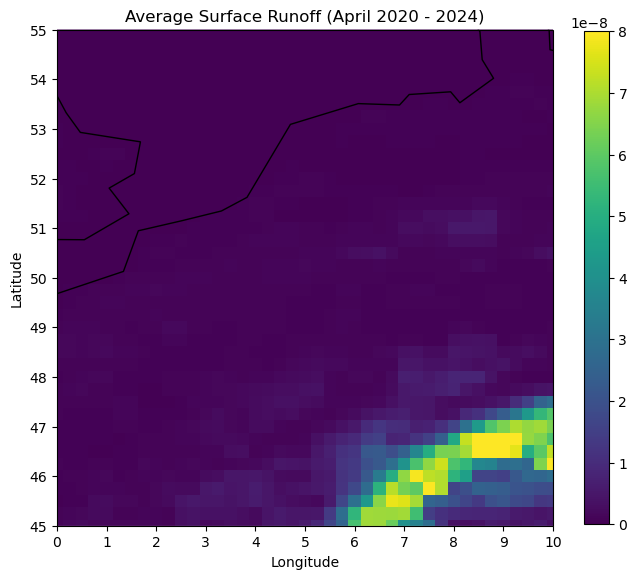

In [40]:
fig, axs = plt.subplots(figsize=(8,8), facecolor="white",subplot_kw={'projection': ccrs.PlateCarree()})

axs.pcolormesh(lons28_sfc, lats28_sfc, sample_sfc_sro[::-1], transform=ccrs.PlateCarree(), vmin=0, vmax=8e-8)
# Cutout Rhine basin
axs.set_ylim([45,55])
axs.set_xlim([0,10])
axs.set_yticks(np.linspace(45,55,11))
axs.set_xticks(np.linspace(0,10,11))
axs.coastlines(resolution='110m', color='k')
# Add titles and labels to the map
axs.set_title(f'Average Surface Runoff (April 2020 - 2024)')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')
fig.colorbar(axs.pcolormesh(lons28_sfc, lats28_sfc, sample_sfc_sro[::-1], transform=ccrs.PlateCarree(), vmin=0, vmax=8e-8), ax=axs, orientation='vertical', pad=0.05, shrink=0.8)

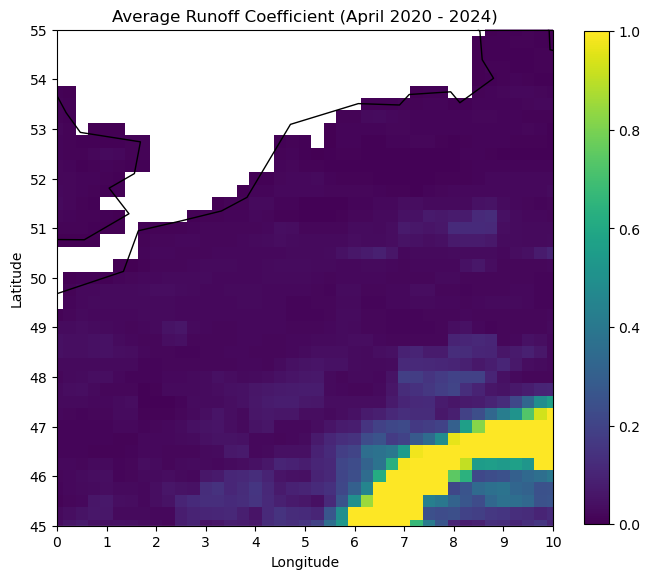

In [41]:
fig, axs = plt.subplots(figsize=(8,8), facecolor="white",subplot_kw={'projection': ccrs.PlateCarree()})

axs.pcolormesh(lons28_sfc, lats28_sfc, sample_sfc_RC[::-1], transform=ccrs.PlateCarree(), vmin=0, vmax=1)
# Cutout Rhine basin
axs.set_ylim([45,55])
axs.set_xlim([0,10])
axs.set_yticks(np.linspace(45,55,11))
axs.set_xticks(np.linspace(0,10,11))
axs.coastlines(resolution='110m', color='k')
# Add titles and labels to the map
axs.set_title(f'Average Runoff Coefficient (April 2020 - 2024)')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')
fig.colorbar(axs.pcolormesh(lons28_sfc, lats28_sfc, sample_sfc_RC[::-1], transform=ccrs.PlateCarree(), vmin=0, vmax=1), ax=axs, orientation='vertical', pad=0.05, shrink=0.8)

## Time series of CaMa-Flood river discharge output

### and compare with GSFC station observations of river discharge wherever possible.

In [46]:
ds28 = cat.IFS['IFS_28-NEMO_25-cycle3']['2D_1h_camaflood'].to_dask() # load hourly CaMa-Flood output at 0.25 degree regular lat/lon grid resolution
ds9 = cat.IFS['IFS_9-NEMO_25-cycle3']['2D_1h_camaflood'].to_dask() # load hourly CaMa-Flood output at 0.25 degree regular lat/lon grid resolution

In [7]:
# Get the observations
path_obs = '/home/b/b301048/NextGEMS_hackathon/Observations/'
obs = xr.open_dataset(path_obs + 'station_attributes_with_obsdis24h_197001-202312_v4.0_20240216_withEFAS.nc')
# But from the observations, keep stations only when provider1 == GRDC | provider2 == GRDC & qflag_3min == 1
station_id = obs.station_id.values
provider1 = obs.provider1.values
provider2 = obs.provider2.values
qflag_3min = obs.qflag_3min.values
CamaLon1_6min = obs.CamaLon1_6min.values
CamaLat1_6min = obs.CamaLat1_6min.values
tokeep_provider1 = np.where(provider1 == 'GRDC')
tokeep_provider2 = np.where(provider2 == 'GRDC')
tokeep_provider = np.append(tokeep_provider1, tokeep_provider2)
tokeep_qflag_3min = np.where(qflag_3min == 1)
tokeep_all = find_common_elements(tokeep_provider, tokeep_qflag_3min[0])
print(len(tokeep_all)) # our observational file should have 962 stations
obs_ng = obs.where(obs.station.isin(tokeep_all),drop=True)

962


In [8]:
obs_ng

<xarray.Dataset>
Dimensions:                                (station: 962, time: 19723)
Coordinates:
  * time                                   (time) datetime64[ns] 1970-01-01 ....
Dimensions without coordinates: station
Data variables: (12/96)
    lon                                    (station) float32 72.37 ... 17.33
    lat                                    (station) float32 126.8 ... 96.5
    providedlon                            (station) float32 126.8 ... 96.5
    providedlat                            (station) float32 72.37 ... 17.33
    providedups                            (station) float32 2.46e+06 ... 2.5...
    station_id_num                         (station) float64 1.0 ... 4.649e+03
    ...                                     ...
    stationname                            (station) object Stolb ... Bago
    rivername                              (station) object Lena Olenek ... Pegu
    continent                              (station) object Asia Asia ... Asia
    country                                (station) object RUSSIAN FEDERATIO...
    station_id                             (station) object 'G0001' ... 'G4649'
    obsdis                                 (time, station) float32 2.27e+03 ....

In [9]:
# Find out which stations are at the Rhine
# For this, use the 6min (0.25deg) CaMa-Flood lons and lats to which the stations have been mapped
station_lons_Rhine = obs_ng.where(obs_ng.rivername == "Rhine",drop=True).CamaLon1_6min.values
station_lats_Rhine = obs_ng.where(obs_ng.rivername == "Rhine",drop=True).CamaLat1_6min.values
station_id_Rhine = obs_ng.where(obs_ng.rivername == "Rhine",drop=True).station_id.values
station_Rhine = obs_ng.where(obs_ng.rivername == "Rhine",drop=True).station_id_num.values.astype(int)
stationname_Rhine = obs_ng.where(obs_ng.rivername == "Rhine",drop=True).stationname.values

In [10]:
lons9 = np.linspace(min(ds9.lon.values),round(max(ds9.lon.values),2),len(np.unique(ds9.lon.values)))
lats9 = np.linspace(max(ds9.lat.values),min(ds9.lat.values),len(np.unique(ds9.lat.values)))
lons_Rhine = np.where((lons9 > 0) & (lons9 < 10))
lats_Rhine = np.where((lats9 > 45) & (lats9 < 55))

In [11]:
# Print all station names which have observations on the Rhine.
for x in stationname_Rhine:
    print(x)

Lobith
Rees
Duesseldorf
Koeln
Andernach
Kaub
Mainz
Worms
Speyer
Maxau
Rheinfelden
Basel Rheinhalle


In [12]:
# Create a sample for the Rhine basin
sample = np.reshape(ds9['dis'].isel(time=10).values, newshape=(len(np.unique(ds9.lat)),len(np.unique(ds9.lon))))
sample_Rhine = sample[(lats_Rhine[0][0]):(lats_Rhine[0][-1]), lons_Rhine[0][0]:lons_Rhine[0][-1]]

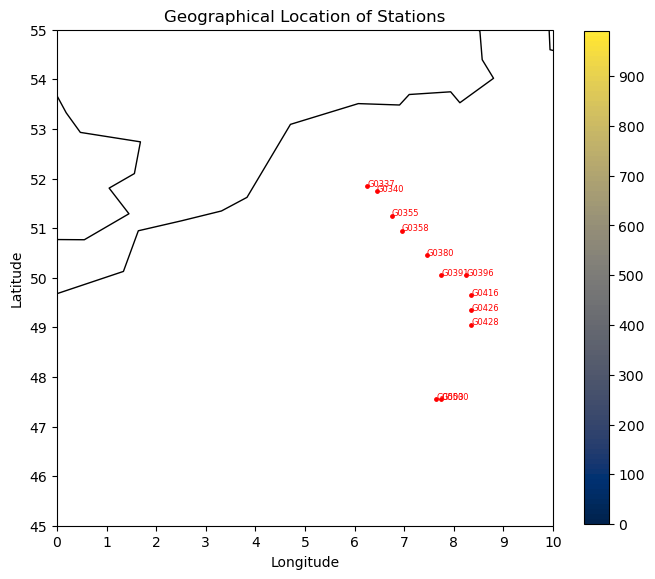

In [13]:
# Plot the stations on a map to see where they are
fig, axs = plt.subplots(figsize=(8,8), facecolor="white",subplot_kw={'projection': ccrs.PlateCarree()})

cmap=cm.cividis
cmapdiff=cm.BrBG

bounds = np.arange(0, 1000, 10)
norm = colors.BoundaryNorm(bounds, cmap.N)

axs.pcolormesh(lons9[lons_Rhine], lats9[lats_Rhine], sample_Rhine,cmap=cmap, transform=ccrs.PlateCarree(),norm=norm)
# add points for stations on the Rhine
axs.scatter(station_lons_Rhine, station_lats_Rhine, facecolor='red', s=6)
# iterate to add station names
for i, txt in enumerate(station_id_Rhine):
    axs.annotate(txt, (station_lons_Rhine[i], station_lats_Rhine[i]), color='red', size=6)
# Cutout Rhine basin
axs.set_ylim([45,55])
axs.set_xlim([0,10])
axs.set_xticks(np.linspace(0,10,11))
axs.set_yticks(np.linspace(45,55,11))
axs.coastlines(resolution='110m', color='k')
# Add titles and labels to the map
axs.set_title(f'Geographical Location of Stations')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')
fig.colorbar(axs.pcolormesh(lons9[lons_Rhine], lats9[lats_Rhine], sample_Rhine,cmap=cmap, transform=ccrs.PlateCarree(),norm=norm), ax=axs, orientation='vertical', pad=0.05, shrink=0.8)

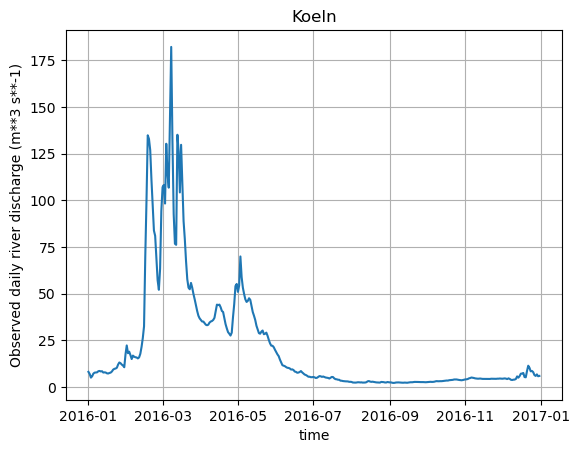

In [58]:
# Plot the last year of discharge values at the Rhine, Koeln
# Find out which is the last year of full data
last_full_year = str(int(str(obs_ng.enddate.values[station_Rhine[3]])[:4])-1)
fix, ax = plt.subplots()
# ax.plot(obs_ng.time.values[0:365], obs_ng.obsdis.values[0:,station_Rhine[3]][0:365])
ax.plot(obs_ng.sel(station=station_Rhine[3], time=last_full_year).time.values, obs_ng.sel(station=station_Rhine[3], time=last_full_year).obsdis.values)
ax.set(xlabel='time', ylabel='Observed daily river discharge (m**3 s**-1)',
       title=stationname_Rhine[3])
ax.grid()

In [57]:
# Get the CaMa-Flood river discharge output at the Koeln station
# Find the index of the closest lat and lon in the coordinates
lat_idx = np.abs(ds9['lat'].values - station_lons_Rhine[3]).argmin()
lon_idx = np.abs(ds9['lon'].values - station_lons_Rhine[3]).argmin()

# Extract the nearest lat/lon
nearest_lat = ds9['lat'].values[lat_idx]
nearest_lon = ds9['lon'].values[lon_idx]

lats = np.where(ds9['lat'].values == nearest_lat)
lons = np.where(ds9['lon'].values == nearest_lon)

idx = find_common_elements(lats[0].flatten(),lons[0].flatten())[0]

time_series_Koeln = ds9.dis.isel(value=idx)
# Is there a faster way of extracting single point values? This takes forever...
# Avoiding the lazy-loading is probably not an option? 
time_series_Koeln_loaded = time_series_Koeln.load()

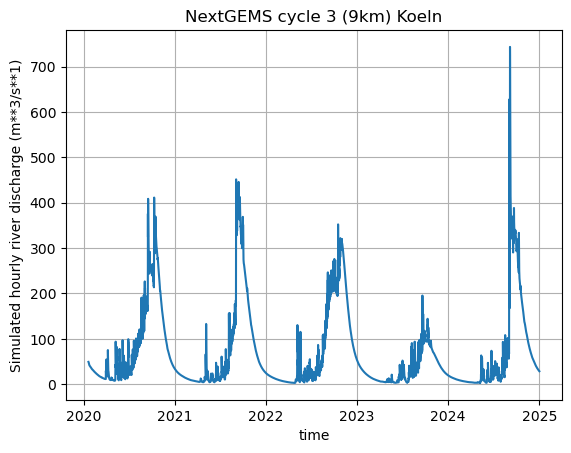

In [59]:
# plot the time series for the simulated river discharge
fix, ax = plt.subplots()
ax.plot(time_series_Koeln_loaded.time.values, time_series_Koeln_loaded.values)
ax.set(xlabel='time', ylabel='Simulated hourly river discharge (m**3 s**-1)',
       title='NextGEMS cycle 3 (9km) ' + stationname_Rhine[3])
ax.grid()

 ## Flow duration durves: displays the how much % of the time a certain value of river discharge is exceeded

### and compare with GSFC station observations of river discharge wherever possible.

In [60]:
# Flow Duration Curve for NextGEMS cycle 3 (~5 years)
# As the simulations have hourly values, compute daily averages first
time_series_Koeln_av24h = time_series_Koeln_loaded.resample(time="24h").mean()
time_series_Koeln_ng3_n = np.linspace(1,
                                  len(time_series_Koeln_av24h.values),
                                  len(time_series_Koeln_av24h.values),dtype='int')
time_series_Koeln_ng3_pc = time_series_Koeln_ng3_n/len(time_series_Koeln_av24h.values)*100
time_series_Koeln_ng3_sort = np.sort(time_series_Koeln_av24h.values)[::-1]

In [61]:
# Flow duration curve for observations (~47 years)
obs_ng_Koeln_nonan = obs_ng.obsdis.values[0:,station_Rhine[3]][~np.isnan(obs_ng.obsdis.values[0:,station_Rhine[3]])]
time_series_Koeln_obs_n = np.linspace(1,
                                  len(obs_ng_Koeln_nonan),
                                  len(obs_ng_Koeln_nonan),dtype='int')
time_series_Koeln_obs_pc = time_series_Koeln_obs_n/len(obs_ng_Koeln_nonan)*100
time_series_Koeln_obs_sort = np.sort(obs_ng_Koeln_nonan)[::-1]

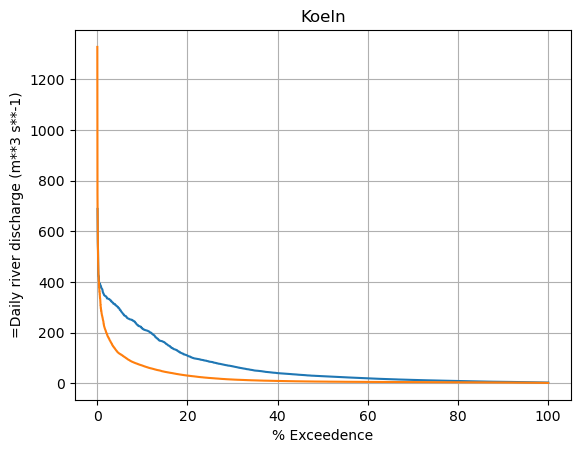

In [62]:
fix, ax = plt.subplots()
ax.plot(time_series_Koeln_ng3_pc, time_series_Koeln_ng3_sort,label="ng3 (9km; 2020-2024)")
ax.plot(time_series_Koeln_obs_pc, time_series_Koeln_obs_sort,label="obs (1970-2016)")
ax.set(xlabel='% Exceedence', ylabel='=Daily river discharge (m**3 s**-1)',
       title=stationname_Rhine[3])
ax.legend()
ax.grid()

## Baseflow Index

## Baseflow Index

### Baseflow / total streamflow
#### Baseflow can be computed as minimum daily streamflow per month averaged over all calendar months.

## Extremes

### Do the most extreme catchment sums of precipitation / surface runoff result in the most extreme river discharge peaks?

### Are the most extreme river discharge peaks preceded by the most extreme catchment sums of precipitation / surface runoff?